In [ ]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import matplotlib
import pandas as pd
import seaborn as sns
import torch

import block_formats.analysis as A
import block_formats.quantisation as Q

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def distribution_name(distribution: A.Distribution) -> str:
    if isinstance(distribution, A.StudentT):
        return f"t[$\\nu={distribution.df:.0f}$]"
    return type(distribution).__name__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
rows = []
for dist in [A.Normal(), A.Laplace(), A.StudentT(df=5)]:
    X = dist.sample(2**24, seed=1, device=DEVICE)
    for bits in [4, 8]:
        for block_size in [32, 64, 128]:
            for fmt, fmt_name in [(Q.IntFormat, "INT"), (lambda b: dist.quantiser(b, scaling="absmax", block_size=block_size), "CRD")]:
                for mbits in list(range(23)):
                    scaled_fmt = Q.LinearScalingFormat(
                        fmt(bits - (mbits + 8) / block_size), Q.FPFormat(7, mbits, "to_inf"), (block_size,), scaling="absmax",
                    )
                    rows.append(dict(
                        dist=distribution_name(dist),
                        bits=bits,
                        block_size=block_size,
                        fmt=fmt_name,
                        scale_mantissa_bits=mbits,
                        rmse=A.qrmse_norm(scaled_fmt, X).item(),
                        actual_bits=scaled_fmt.count_bits(X.shape) / X.nelement(),
                    ))
df = pd.DataFrame.from_records(rows)

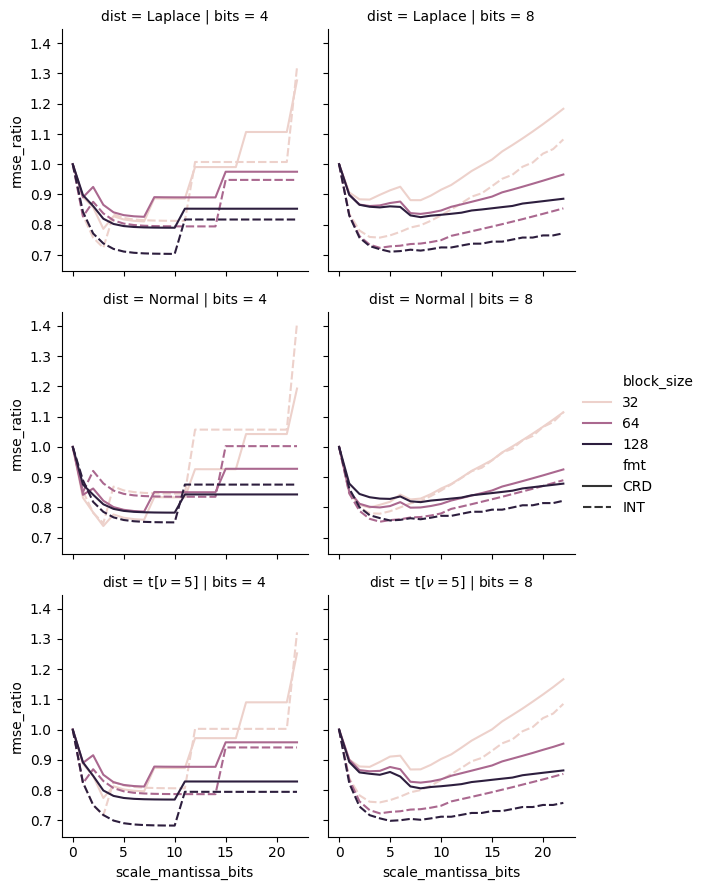

In [ ]:
d = df.groupby(["dist", "bits", "fmt", "block_size"]).apply(lambda d: d.assign(rmse_ratio=d.rmse/d[d.scale_mantissa_bits==0].rmse.iloc[0]), include_groups=False).reset_index()

g = sns.relplot(data=d, y="rmse_ratio", x="scale_mantissa_bits",
                hue="block_size", hue_norm=matplotlib.colors.LogNorm(), col="bits", style="fmt", row="dist",
                kind="line", height=3)